In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pandas as pd
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
torch.save(model.state_dict(), 'model')

RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [75]:
model.load_state_dict(torch.load('model_1D_1024'))
model.eval()

AE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.35, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.35, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (9): ReLU()
    (10): Dropout(p=0.35, inplace=False)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (13): ReLU()
    (14): Dropout(p=0.35, inplace=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=3840, out_features=1024, bias=True)
    (17): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1024, out_features=3840, bias=True)
    (1): ReLU()
    (2): Unflatten(di

In [2]:
class CelebA(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file, delimiter=',')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0])
        image = PIL.Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        blink = self.df.iloc[idx, 1]
        return image, blink
    
tensor_transform = transforms.ToTensor()
dataset = CelebA(root_dir = r"C:\Users\Arek\Desktop\praca magisterska\dataset\eyes\lewe_oko",
                         csv_file = r"C:\Users\Arek\Desktop\praca magisterska\dataset\eyes\eyes.csv",
                         transform = tensor_transform)
train_size = 250000
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
print('train_set=',len(train_set), 'test_set=', len(test_set))

batch_size = 28
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                     batch_size = batch_size,
                                     shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                     batch_size = batch_size,
                                     shuffle = True)

train_set= 250000 test_set= 23784


In [74]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, 7, 1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.35),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 64, 7, 1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.35),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 64, 5, 1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.35),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 64, 5, 1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.35),
            torch.nn.Flatten(),
            torch.nn.Linear(3840,1024),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(1024,3840),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1,(64,10,6)),
            torch.nn.ConvTranspose2d(64, 64, 5, 1),
            torch.nn.ReLU(),
            torch.nn.Upsample(size=(20,29), mode='nearest'),
            torch.nn.ConvTranspose2d(64, 64, 5, 1),
            torch.nn.ReLU(),
            torch.nn.Upsample(size=(48,66), mode='nearest'),
            torch.nn.ConvTranspose2d(64, 64, 7, 1),
            torch.nn.ReLU(),
            torch.nn.Upsample(size=(109,144), mode='nearest'),
            torch.nn.ConvTranspose2d(64, 3, 7, 1),
            torch.nn.Sigmoid()
        )
        self.x_mean = np.load('x_mean.npy')
        self.eigenvectors = np.load('eigenvectors.npy')

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def get_z(self, x):
        return self.encoder(x)
    
    def change_feature(self, x, bias):
        x = self.encoder(x)
        x = x.cpu().numpy()
        x = x - self.x_mean
        z = x@self.eigenvectors.T
        z[0,0] = z[0,0] + bias
        x = z@np.linalg.inv(self.eigenvectors.T)
        x = x + self.x_mean
        x = torch.tensor(x.astype(np.float32)).to(device)
        decoded = self.decoder(x)
        return decoded
    
model = AE().to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.0002)

In [4]:
from torchsummary import summary
summary(model, (3, 115, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 109, 144]           9,472
              ReLU-2         [-1, 64, 109, 144]               0
           Dropout-3         [-1, 64, 109, 144]               0
         MaxPool2d-4           [-1, 64, 54, 72]               0
            Conv2d-5           [-1, 64, 48, 66]         200,768
              ReLU-6           [-1, 64, 48, 66]               0
           Dropout-7           [-1, 64, 48, 66]               0
         MaxPool2d-8           [-1, 64, 24, 33]               0
            Conv2d-9           [-1, 64, 20, 29]         102,464
             ReLU-10           [-1, 64, 20, 29]               0
          Dropout-11           [-1, 64, 20, 29]               0
        MaxPool2d-12           [-1, 64, 10, 14]               0
           Conv2d-13            [-1, 64, 6, 10]         102,464
             ReLU-14            [-1, 64

nauka:

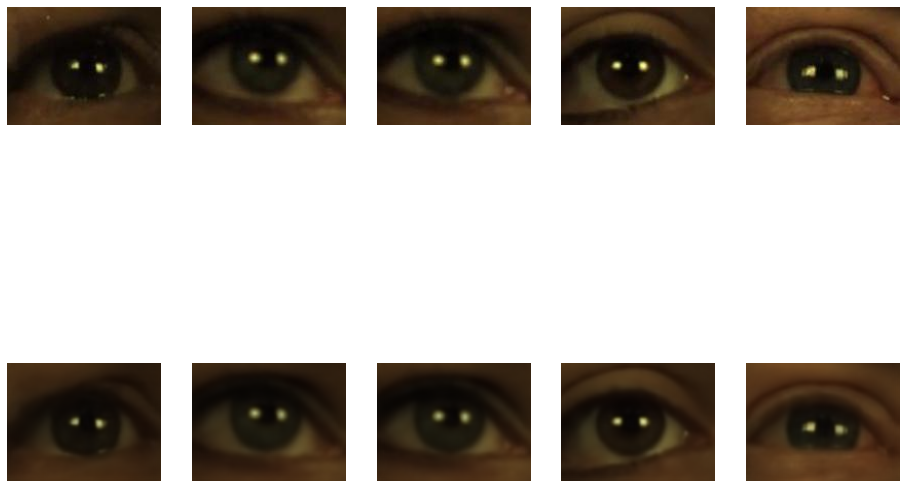

 Epoch 10, batch [ 8929/ 8929]	 loss: 0.000218	 test loss: 0.001007


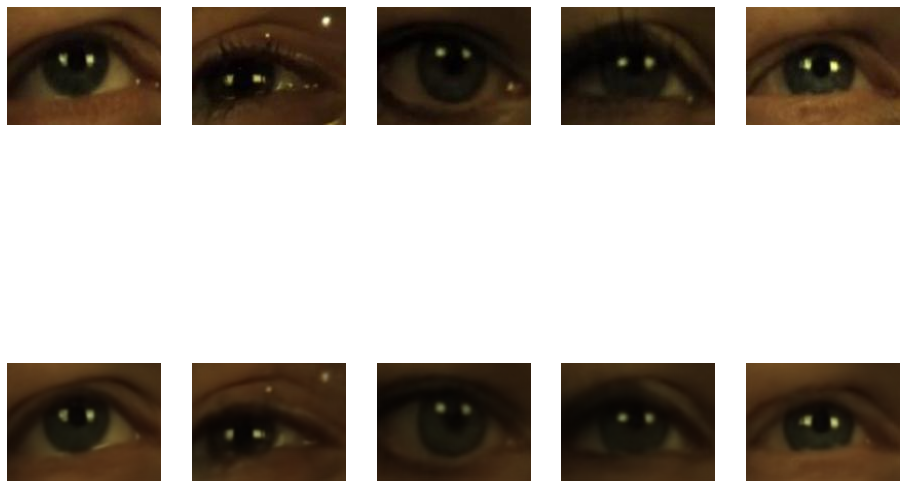

 Epoch 11, batch [ 8929/ 8929]	 loss: 0.000216	 test loss: 0.000927


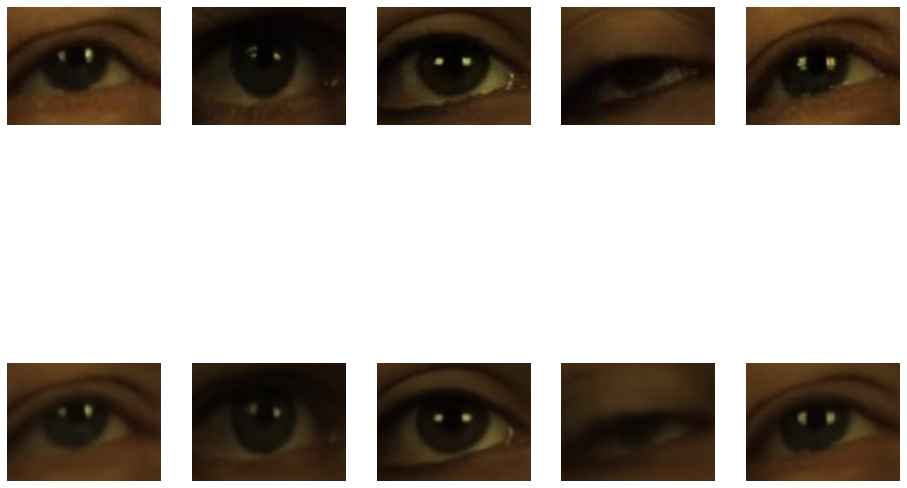

 Epoch 12, batch [ 8929/ 8929]	 loss: 0.000215	 test loss: 0.001017


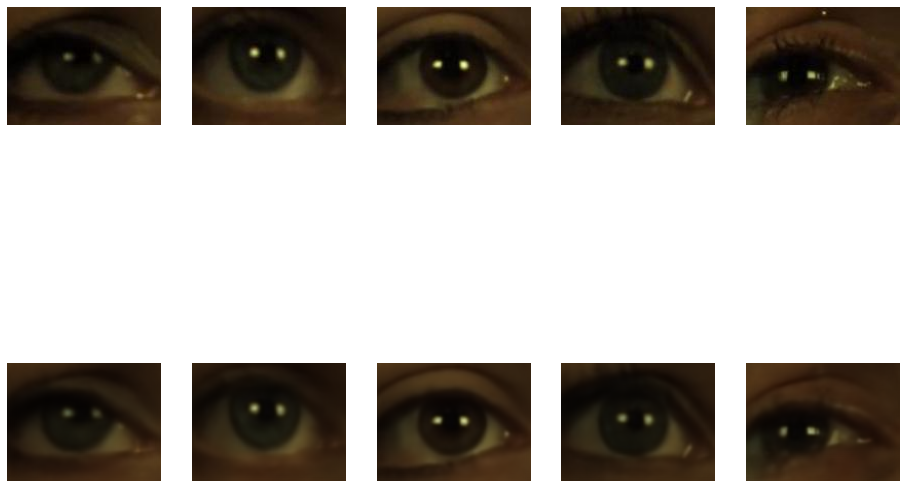

 Epoch 13, batch [ 8929/ 8929]	 loss: 0.000214	 test loss: 0.000988


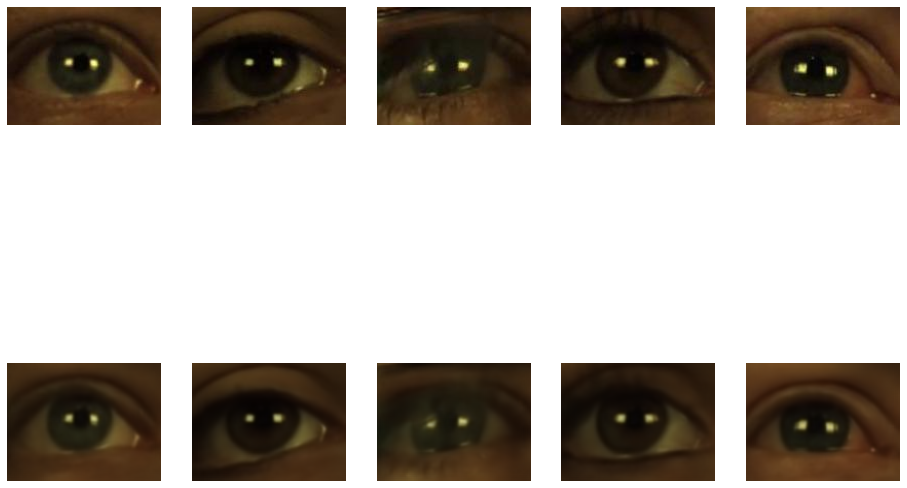

 Epoch 14, batch [ 8929/ 8929]	 loss: 0.000213	 test loss: 0.000983


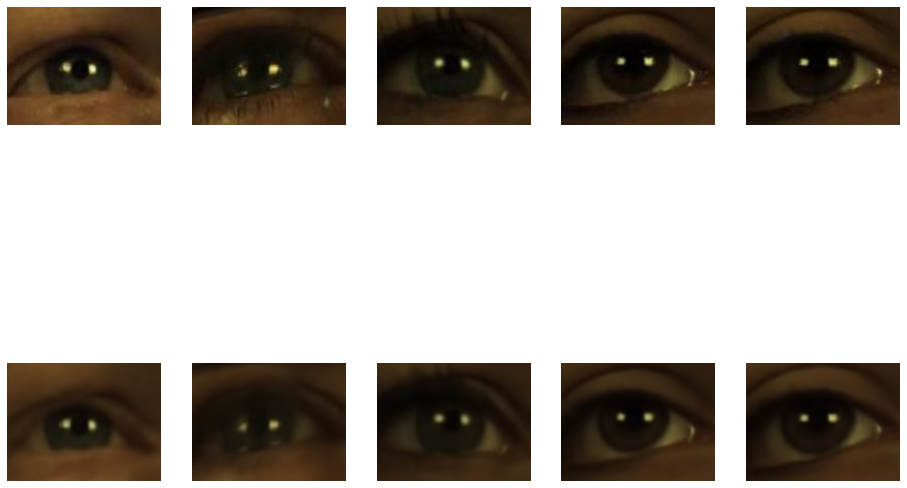

 Epoch 15, batch [  660/ 8929]	 loss: 0.000214

KeyboardInterrupt: 

In [5]:
def draw():
    with torch.no_grad():
        fig = plt.figure(figsize=(16, 12))
        model.eval()
        for i, (image, y) in enumerate(test_loader):
            image = image.to(device)
            pred = model(image)
            image = image.cpu()
            pred = pred.cpu()
            sample = image[0].numpy()
            sample = sample.swapaxes(0, 1)
            sample = sample.swapaxes(1, 2)
            ax = plt.subplot(2, 5, i + 1)
            ax.axis('off')
            plt.imshow(sample)
            sample = pred[0].numpy()
            sample = sample.swapaxes(0, 1)
            sample = sample.swapaxes(1, 2)
            ax = plt.subplot(2, 5, 5 + i + 1)
            ax.axis('off')
            plt.imshow(sample)
            if i >= 4:
                plt.show(block = False)
                plt.close()
                break


train_size, test_size = len(train_loader.dataset), len(test_loader.dataset)
for epoch in range(9,100):
    draw()
    model.train()
    train_loss = 0
    for i, (image, y) in enumerate(train_loader):
        image = image.to(device)
        pred = model(image)
        loss = loss_function(pred, image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loss= train_loss / (i+1)
        print(f"\r Epoch {epoch+1}, batch [{i+1:>5d}/{int(np.ceil(train_size/batch_size)):>5d}]\t loss: {loss:>7f}", end="")

    test_loss = 0
    with torch.no_grad():
        model.eval()
        for (image, y) in test_loader:
            image = image.to(device)
            pred = model(image)
            test_loss += loss_function(pred, image).item()
    
    test_loss = test_loss / len(test_loader)
    print(f"\t test loss: {test_loss:>7f}")
    torch.save(model.state_dict(), 'model_1D_1024')

zebranie danych z latenspace'a (z):

In [23]:
tab = list()
y_list = list()
with torch.no_grad():
    model.eval()
    for i, (image,y) in enumerate(train_loader):
        image = image.to(device)
        z = model.get_z(image)
        z = z.cpu().numpy()
        y = y.numpy()
        for j in range(z.shape[0]):
            tab.append(z[j])
            y_list.append(y[j])
        print("\r i=",i, end="")
        
x = np.array(tab)
y = np.array(y_list)
with open('z.npy', 'wb') as f:
    np.save(f, x)
with open('y.npy', 'wb') as f:
    np.save(f, y)
print(x.shape, y.shape)

 i= 8928(250000, 1024) (250000,)


SPCA:

In [69]:
y = np.load('y.npy')
x = np.load('z.npy')
x_mean = np.mean(x,axis=0) 
x = x - x_mean
y_mean = np.mean(y) 
y = y - y_mean
print(x.shape, y.shape)

(250000, 1024) (250000,)


In [70]:
Cxy = x.T@y
Cxy = Cxy.reshape((1024,1))
C = Cxy@Cxy.T
print("C_shape", C.shape)

C_shape (1024, 1024)


In [71]:
eigenvalues, eigenvectors = np.linalg.eigh(C)
eigenvectors = eigenvectors.T
indx = np.argsort(eigenvalues)[::-1]
eigenvectors = eigenvectors[indx]
eigenvalues = eigenvalues[indx]
print(eigenvalues[:10])

[1.84810965e+08 9.04615524e-08 8.52967056e-08 6.62656455e-08
 6.08355920e-08 5.77965932e-08 3.82887785e-08 3.67300733e-08
 3.48419701e-08 3.22923385e-08]


In [72]:
z = np.random.rand(1,1024)
print(z)
a = z@eigenvectors
print(a)
z = a@np.linalg.inv(eigenvectors)
print(z)

[[0.36753452 0.68923193 0.27003194 ... 0.80967189 0.43393257 0.16676143]]
[[ 0.9254854  -0.80314141  0.39276249 ...  0.72841582 -0.43576639
   0.83563879]]
[[0.36753452 0.68923193 0.27003194 ... 0.80967189 0.43393257 0.16676143]]


In [73]:
with open('x_mean.npy', 'wb') as f:
    np.save(f, x_mean)
with open('eigenvectors.npy', 'wb') as f:
    np.save(f, eigenvectors)

testowanie zmiany cech:

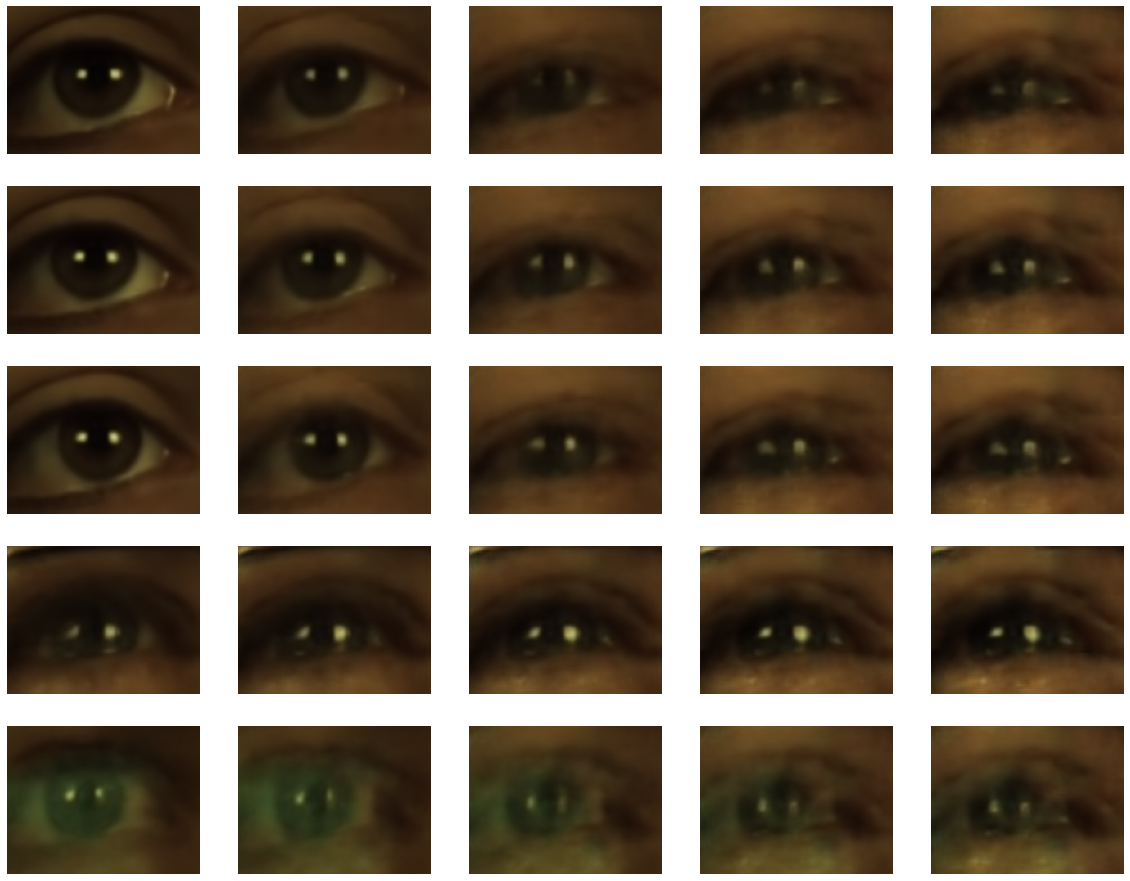

In [79]:
def draw():
    bias = -1# parametr mówiący o wielkości zmiany parametru na kolejnych zdjęciach
    with torch.no_grad():
        fig = plt.figure(figsize=(20, 16))
        model.eval()
        for (image, y) in test_loader:
            for j in range(5):
                x = image[j].view(1,3,115,150).to(device)
                for i in range(5):
                    pred = model.change_feature(x,bias*i)
                    pred = pred.cpu()
                    sample = pred[0].numpy()
                    sample = sample.swapaxes(0, 1)
                    sample = sample.swapaxes(1, 2)
                    ax = plt.subplot(5, 5, j*5 + i+1)
                    ax.axis('off')
                    plt.imshow(sample)
            plt.show(block = False)
            plt.close()
            break
draw()

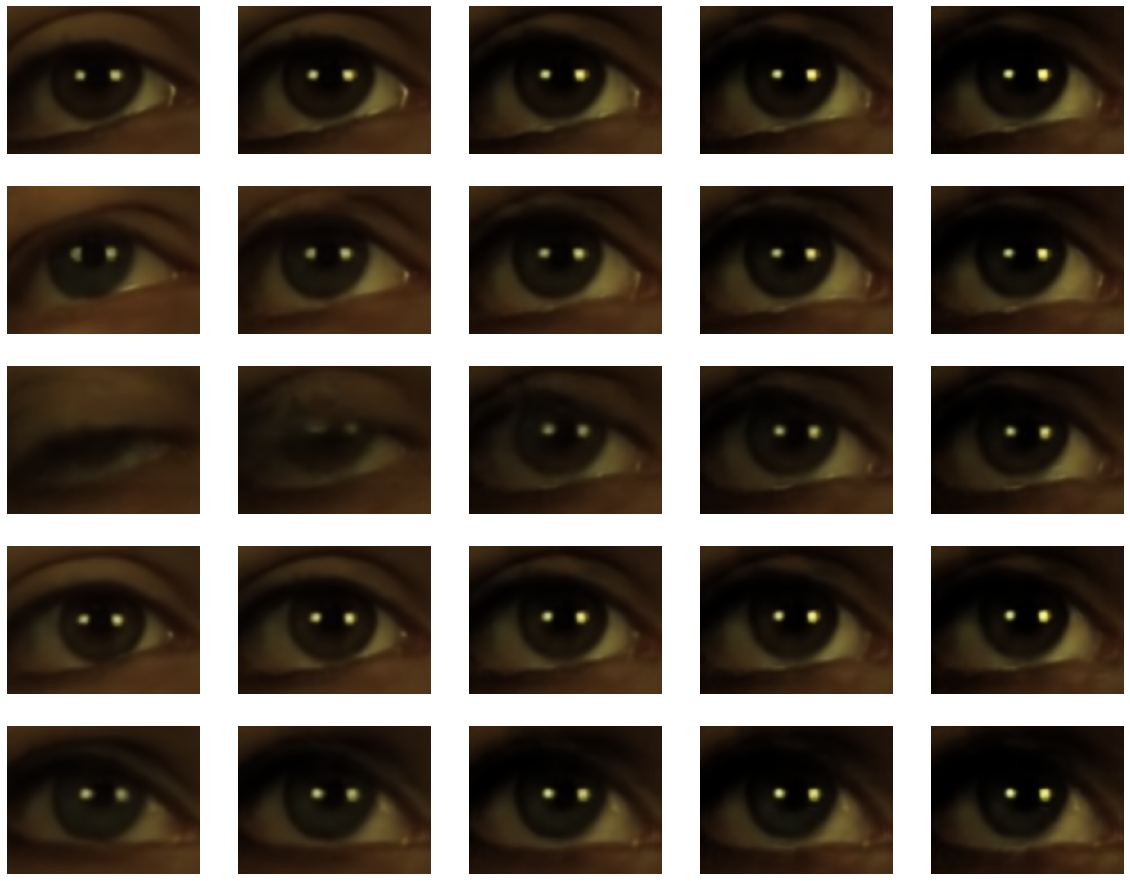

In [77]:
def draw():
    bias = 1
    with torch.no_grad():
        fig = plt.figure(figsize=(20, 16))
        model.eval()
        for (image, y) in test_loader:
            for j in range(5):
                x = image[j].view(1,3,115,150).to(device)
                for i in range(5):
                    pred = model.change_feature(x,bias*i)
                    pred = pred.cpu()
                    sample = pred[0].numpy()
                    sample = sample.swapaxes(0, 1)
                    sample = sample.swapaxes(1, 2)
                    ax = plt.subplot(5, 5, j*5 + i+1)
                    ax.axis('off')
                    plt.imshow(sample)
            plt.show(block = False)
            plt.close()
            break
draw()